In [0]:
!apt-get update 
!apt-get install -y cmake swig python-opengl ffmpeg xvfb

!pip install joblib six
!pip install 'gym[all]'
!pip install pyglet==1.2.4
!pip install pyvirtualdisplay
!pip install --no-cache-dir -I pillow
!pip install tqdm
!pip install --upgrade scipy

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake i

Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.3.0)


In [0]:
# создаем фиктивный дисплей:
!pkill -9 Xvfb
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

# Deep Q-Network implementation

This notebook shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

In [0]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import matplotlib 
matplotlib.rcParams['grid.alpha'] = 0

from google.colab import files

### Let's play some old videogames
![](http://ichef.bbci.co.uk/news/976/cpsprodpb/5A98/production/_96529132_bbc_atari.jpg)

This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.


### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [0]:
from gym.core import ObservationWrapper
from gym.spaces import Box

from skimage.transform import resize

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _observation(self, img):
        """what happens to each observation"""
        
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size 
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        
        img = img[30:30 + 175]
        img = resize(img, (self.img_size[1], self.img_size[2])).mean(-1)
        img = img.astype(np.float32)
        img /= 255.
        
        return np.expand_dims(img, axis=0)

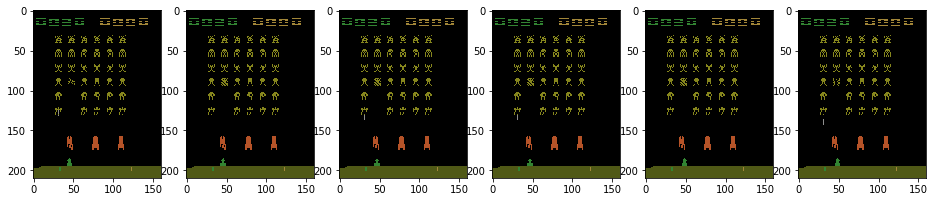

In [0]:
import gym
game_name = "SpaceInvadersDeterministic-v4"
#spawn game instance for tests
env = gym.make(game_name) 
env.reset()
ax = plt.figure(figsize=(16,4))

for i in range(100):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.subplot(1,6,1)
obs, _, _, _ = env.step(env.action_space.sample())
plt.imshow(obs,interpolation='none');
plt.subplot(1,6,2)
obs, _, _, _ = env.step(env.action_space.sample())
plt.imshow(obs,interpolation='none');
plt.subplot(1,6,3)
obs, _, _, _ = env.step(env.action_space.sample())
plt.imshow(obs,interpolation='none');
plt.subplot(1,6,4)
plt.imshow(obs,interpolation='none');
plt.subplot(1,6,5)
obs, _, _, _ = env.step(env.action_space.sample())
plt.imshow(obs,interpolation='none');
plt.subplot(1,6,6)
obs, _, _, _ = env.step(env.action_space.sample())
plt.imshow(obs,interpolation='none');

Formal tests seem fine. Here's an example of what you'll get.


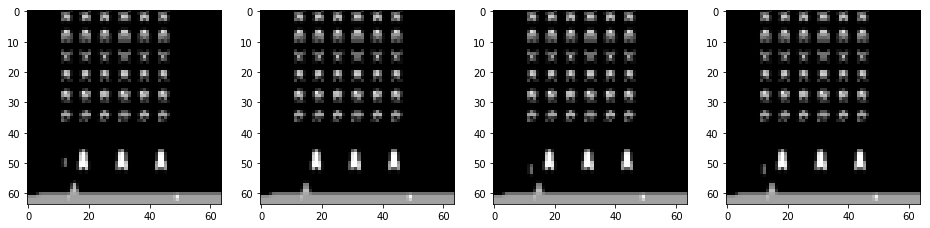

In [0]:
import gym
#spawn game instance for tests
env = gym.make(game_name) #create raw env
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

env.reset()


ax = plt.figure(figsize=(16,4))

for i in range(100):
    obs, _, _, _ = env.step(env.action_space.sample())
    
plt.subplot(1,4,1)
obs, _, _, _ = env.step(env.action_space.sample())
plt.imshow(obs[0, :, :],interpolation='none',cmap='gray');
plt.subplot(1,4,2)
obs, _, _, _ = env.step(env.action_space.sample())
plt.imshow(obs[0, :, :],interpolation='none',cmap='gray');
plt.subplot(1,4,3)
obs, _, _, _ = env.step(env.action_space.sample())
plt.imshow(obs[0, :, :],interpolation='none',cmap='gray');
plt.subplot(1,4,4)
plt.imshow(obs[0, :, :],interpolation='none',cmap='gray');

#test observation
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs))>2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

print("Formal tests seem fine. Here's an example of what you'll get.")

### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to fing optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [0]:
import numpy as np
from gym.spaces.box import Box
from gym.core import Wrapper
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

In [0]:
def make_env():
    env = gym.make("SpaceInvadersDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

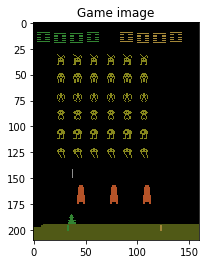

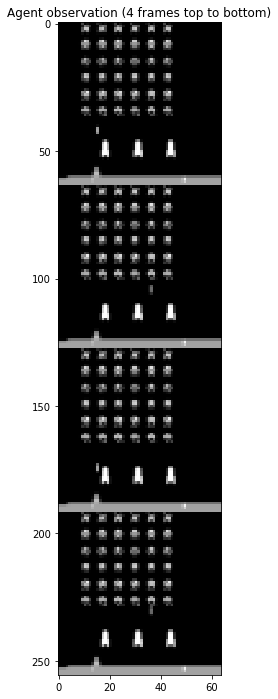

In [0]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.figure(figsize=(3,12)) 
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_dim[2]]),interpolation='none',cmap='gray');
plt.grid(False)

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

     |████████████████████████████████| 592.3MB 1.3MB/s 
ERROR: fastai 1.0.52 has requirement torch>=1.0.0, but you'll have torch 0.3.0.post4 which is incompatible.


In [0]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
gpu = torch.cuda.is_available()


class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        """A simple DQN agent"""
        nn.Module.__init__(self)
        self.epsilon = epsilon
        self.n_actions = n_actions
        img_c, img_w, img_h = state_shape
        
        self.conv1 = nn.Conv2d(img_c, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(800, n_actions)

    def forward(self, state_t):
        """
        takes agent's observation (Variable), returns qvalues (Variable)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        Hint: if you're running on GPU, use state_t.cuda() right here.
        """
        
        # Use your network to compute qvalues for given state
        if gpu:
            state_t = state_t.cuda()
        
        x = F.relu(self.bn1(self.conv1(state_t)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        qvalues = x
        
        assert isinstance(qvalues, Variable) and qvalues.requires_grad, "qvalues must be a torch variable with grad"
        assert len(qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions
        
        return qvalues
    
    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not Variables
        """
        states = Variable(torch.FloatTensor(np.asarray(states)))
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [0]:
agent = DQNAgent(state_dim, n_actions, epsilon=0.5)
if gpu:
    agent = agent.cuda()

Now let's try out our agent to see if it raises any errors.

In [0]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for game_i in range(n_games):
        s = env.reset()
        reward = 0
        for t_i in range(t_max):
            qvalues = agent.get_qvalues([s])
            if game_i == 0 and t_i > 100 and t_i < 150:
                print(qvalues)
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: 
                break

        rewards.append(reward)
    return np.mean(rewards)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [0]:
# This code is shamelessly stolen from https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
import numpy as np
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


In [0]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [0]:
def play_and_record(agent, env, s, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.
    :returns: return average reward over time
    """

    # Play the game for n_steps as per instructions above
    reward = 0
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        new_s, r, done, _ = env.step(action)
        exp_replay.add(s,action,r,new_s,done)
        reward += r
        s = new_s
        if done:
            s = env.reset()
    return s    

In [0]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

s = env.reset()
play_and_record(agent, env, s, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction. 
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"%(np.mean(is_dones), len(exp_replay))
    
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s"%str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s"%str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s"%str(is_done_batch.shape)
    assert [int(i) in (0,1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"
    
print("Well done!")

### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$


In [0]:
target_network = DQNAgent(state_dim, n_actions)
if gpu:
    target_network = target_network.cuda()

In [0]:
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())
target_network.eval()

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.
__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [0]:
def to_one_hot(y, n_dims=None):
    """ helper: take an integer vector (tensor of variable) and convert it to 1-hot matrix. """
    y_tensor = y.data if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot
    if gpu:
        y_one_hot = y_one_hot.cuda()
    return y_one_hot

def compute_td_loss(states, actions, rewards, next_states, is_done, gamma = 0.99, check_shapes = False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = Variable(torch.FloatTensor(states))    # shape: [batch_size, c, h, w]
    actions = Variable(torch.LongTensor(actions))    # shape: [batch_size]
    rewards = Variable(torch.FloatTensor(rewards))  # shape: [batch_size]
    next_states = Variable(torch.FloatTensor(next_states)) # shape: [batch_size, c, h, w]
    is_done = Variable(torch.FloatTensor(is_done.astype('float32')))  # shape: [batch_size]
    is_not_done = 1 - is_done
    
    if gpu:
        states = states.cuda()
        actions = actions.cuda()
        rewards = rewards.cuda()
        next_states = next_states.cuda()
        is_not_done = is_not_done.cuda()
    
    #get q-values for all actions in current states
    predicted_qvalues = agent(states)
    
    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)

    #select q-values for chosen actions
    predicted_qvalues_for_actions = torch.sum(predicted_qvalues * to_one_hot(actions, n_actions), dim=1)
    

    # compute V*(next_states) using predicted next q-values
    next_state_values, _ = predicted_next_qvalues.max(dim=1) 
    
    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done
    
    #mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2 )
    
    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"
    
    return loss

    

In [0]:
# sanity checks
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, gamma=0.99,
                       check_shapes=True)
loss.backward()

assert isinstance(loss, Variable) and tuple(loss.data.size()) == (1,), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), "loss must be differentiable w.r.t. network weights"

In [0]:
def download_last_video():
    import os
    import time

    dirname = 'videos'
    files_sorted = [x[0] for x in sorted([(fn, os.stat(dirname + '/' + fn)) 
                                   for fn in os.listdir(dirname)], 
                                  key = lambda x: -x[1].st_ctime)]
    video_found = False
    for file in files_sorted:
        if file.endswith(".mp4"):
            files.download(dirname + '/' + file)
            video_found = True
            break
    if not video_found:
        print('Video not found:', files_sorted)

### Main loop

It's time to put everything together and see if it learns anything.

In [0]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import ewma
%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [0]:
# exp_replay = ReplayBuffer(10**5)
s = env.reset()
agent.epsilon = 1
play_and_record(agent, env, s, exp_replay, n_steps=10000);

for i in trange(10**3):
    if i % 100 == 0:
        target_network.load_state_dict(agent.state_dict())
        target_network.eval()
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(64)
    opt.zero_grad()
    loss = compute_td_loss(obs_batch, act_batch, np.zeros_like(reward_batch), 
                           next_obs_batch, is_done_batch, gamma=0,
                           check_shapes=True)
    loss.backward()
    opt.step()

In [0]:
opt = torch.optim.Adam(agent.parameters(), lr=0.001)

In [0]:
import gym.wrappers
from google.colab import files
    
s = env.reset()

for i in trange(10**5):
    
    # play
    s = play_and_record(agent, env, s, exp_replay, 10)
    
    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(64)

    opt.zero_grad()
    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, gamma=0.99,
                           check_shapes=True)
    loss.backward()
    opt.step()

    td_loss_history.append(loss.data.cpu().numpy()[0])
    
    if i % 100 == 0:
        if (agent.state_dict()['conv1.weight'] == 
            target_network.state_dict()['conv1.weight']).all() and i != 0:
            (print('alarm!') for i in range(10))
            print(agent.state_dict()['conv1.weight'] - target_network.state_dict()['conv1.weight'])
            break

        #Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())
        target_network.eval()

    # adjust agent parameters
    if i % 500 == 0:
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)

        env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)
        mean_rw_history.append(evaluate(env_monitor, agent, greedy=True, n_games=3))
        env_monitor.close()
        download_last_video()
        
    if i % 1000 == 0:
        mode_file_name = 'agent_{}.pt'.format(i)
        torch.save(agent, mode_file_name)
        files.download(mode_file_name)
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        plt.figure(figsize=[12, 4])        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()
        
        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(pd.ewma(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()
        
        

In [0]:
assert np.mean(mean_rw_history[-10:]) > 10.
print("That's good enough for tutorial.")

__ How to interpret plots: __


This aint no supervised learning so don't expect anything to improve monotonously. 
* __ TD loss __ is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* __ mean reward__ is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes 5-10k steps to "warm up" agent before it starts to get better.
* __ buffer size__ - this one is simple. It should go up and cap at max size.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - __ it means you need to increase epsilon__. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Also please ignore first 100-200 steps of each plot - they're just oscillations because of the way moving average works.

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

__Training will take time.__ A lot of it actually. An optimistic estimate is to say it's gonna start winning (average reward > 10) after 20k steps. 


In [0]:
torch.save(agent, 'agent_invaders_backup.pt')

### Video

In [0]:
agent.epsilon=0.9 # Don't forget to reset epsilon back to previous value if you want to go on training

In [0]:
evaluate(env, agent, n_games=1, t_max=30000)

In [0]:
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)
evaluate(env_monitor, agent, n_games=2, t_max=10000)
env_monitor.close()
download_last_video()